<a href="https://colab.research.google.com/github/DavidPachis/dataScience/blob/main/taller4/notebook/Taller4CDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller 4**
>FABIAN ORLANDO RAMIREZ ORJUELA fo.ramirez50@uniandes.edu.co <br>
>DAVID AUGUSTO VASQUEZ PACHON da.vasquez11@uniandes.edu.co <br>

>MINE-4101: Ciencia de Dato Aplicada

>Univerisdad de los Andes

>Semestre: 2022-2

## IMPORTACIÓN DE LIBRERÍAS

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
#import keras_tuner as kt
import joblib as jbl
import warnings

warnings.filterwarnings("ignore")

from sklearn import tree

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Ridge, Lasso

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score , classification_report , ConfusionMatrixDisplay

In [ ]:
# Se lee el primer dataset de entrenamiento
url = "https://raw.githubusercontent.com/foramirez50/CDA/main/Taller4/DataSet_Entrenamiento_v1.json"
df = pd.read_json(url)

## FUNCIONES

### FUNCIÓN DE LIMPIEZA

In [ ]:
def cleaning(dataset):
  # se limpia la columna TotalChares que tiene problemas con valores 0 
  dataset.loc[dataset["tenure"] == 0, "TotalCharges"] = "0"
  dataset['TotalCharges'].astype(float)
  # se asocian por tipo las columnas
  objetivo  = dataset["Churn"]
  numericas = dataset[["MonthlyCharges","tenure","SeniorCitizen","TotalCharges"]]
  gender = dataset["gender"]
  categoricas_1 = dataset[['Partner','PhoneService','PaperlessBilling','Dependents']]
  categoricas_2 = dataset[[
      "InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport",
      "StreamingTV","StreamingMovies","Contract","PaymentMethod"
      ]]
  excluidas = dataset[["customerID","MultipleLines"]]

  #se hace la transformación
  objetivo = objetivo.replace(['No', 'Yes'],[0, 1])
  gender = gender.replace(['Female', 'Male'],[0, 1])
  categoricas_1 = categoricas_1.replace(['No', 'Yes'],[0, 1])
  categoricas_2 = pd.get_dummies(categoricas_2)
  numericas = numericas.astype(float)

  #se construye todo el dataset limpio de nuevo
  clean_dataset = pd.DataFrame().join([objetivo,gender,categoricas_1,categoricas_2,numericas], how="outer")
  return clean_dataset

In [ ]:
def cleaning_1(dataset):
  # se limpia la columna TotalChares que tiene problemas con valores 0 
  dataset.loc[dataset["tenure"] == 0, "TotalCharges"] = "0"
  dataset['TotalCharges'].astype(float)
  # se asocian por tipo las columnas
  numericas = dataset[["MonthlyCharges","tenure","SeniorCitizen","TotalCharges"]]
  gender = dataset["gender"]
  categoricas_1 = dataset[['Partner','PhoneService','PaperlessBilling','Dependents']]
  categoricas_2 = dataset[[
      "InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport",
      "StreamingTV","StreamingMovies","Contract","PaymentMethod"
      ]]
  excluidas = dataset[["customerID","MultipleLines"]]

  #se hace la transformación
  gender = gender.replace(['Female', 'Male'],[0, 1])
  categoricas_1 = categoricas_1.replace(['No', 'Yes'],[0, 1])
  categoricas_2 = pd.get_dummies(categoricas_2)
  numericas = numericas.astype(float)

  #se construye todo el dataset limpio de nuevo
  clean_dataset = pd.DataFrame().join([gender,categoricas_1,categoricas_2,numericas], how="outer")
  return clean_dataset

### FUNCIÓN MODELO LOGÍSTICO

In [ ]:
def logistic_model(dataset):

    #dividir el X y Y 
    X = dataset.drop("Churn", axis=1)
    Y = dataset["Churn"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 33)

    scaler = StandardScaler()

    #se hace el pipeline con la regresión logística
    logistic = LogisticRegression(max_iter=1000, tol=0.1, class_weight = 'balanced', multi_class='multinomial', random_state = 33)
    pipe = Pipeline(steps=[("scaler", scaler), ("polynomial", PolynomialFeatures()) ,("logistic", logistic)])
    param_grid = {
        "polynomial__degree": [1, 2],
        "polynomial__interaction_only":[True, False],
        "polynomial__include_bias":[True, False],
        "logistic__penalty":['l2', 'elasticnet'],
        "logistic__solver":['liblinear', 'saga'],    
    }

    #se busca el mejor modelo y regresa el score
    logistic_model = GridSearchCV(pipe, param_grid, n_jobs=2, scoring = 'roc_auc', cv=5).fit(X, Y)
    #score_logistic = roc_auc_score(Y_test, logistic_model.predict_proba(X_test)[:, 1])

    v_score_logistic = cross_val_score(logistic_model, X_train, Y_train, cv=5, scoring='roc_auc').mean()
    
    return v_score_logistic, logistic_model

### FUNCIÓN MODELO DECISION TREE

In [ ]:
def dtree_model(dataset):

    #dividir el X y Y 
    X = dataset.drop("Churn", axis=1)
    Y = dataset["Churn"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 33)

    #se hace el pipeline con la decisition tree
    dtc = tree.DecisionTreeClassifier(class_weight = 'balanced',  random_state = 33)
    pipe = Pipeline([("polynomial", PolynomialFeatures()) ,("dtc", dtc)])

    param_grid = {
        "polynomial__degree": [1, 2],
        "polynomial__interaction_only":[True, False],
        "polynomial__include_bias":[True, False],
        "dtc__splitter": ['best','random'],
        "dtc__criterion": ['gini','entropy','log_loss'],
    }

    search = GridSearchCV(pipe, param_grid, n_jobs=30, scoring = 'roc_auc', cv=5)
    a = search.fit(X, Y)
    best_hyper = search.best_params_

    degree = best_hyper['polynomial__degree']
    interaction_only = best_hyper['polynomial__interaction_only']
    include_bias = best_hyper['polynomial__include_bias']
    splitter = best_hyper['dtc__splitter']
    criterion = best_hyper['dtc__criterion']
    
    poly = PolynomialFeatures(degree=degree,  interaction_only=interaction_only, include_bias=include_bias)
    X_test_scaled = poly.fit_transform(X_test)
    X_train_scaled = poly.fit_transform( X_train)
    X_scaled = poly.fit_transform(X)

    decision_tree = tree.DecisionTreeClassifier(class_weight = 'balanced', criterion = criterion, splitter = splitter, random_state=33).fit(X_train, Y_train)
    #score_decisionTree = roc_auc_score(Y_test, decision_tree.predict_proba(X_test)[:, 1])
    v_score_dtree = cross_val_score(decision_tree, X_train, Y_train, cv=5, scoring='roc_auc').mean()
                                      
    return v_score_dtree, decision_tree

### FUNCIÓN RANDOM FOREST

In [ ]:
def rforest_model(dataset):

    #dividir el X y Y 
    X = dataset.drop("Churn", axis=1)
    Y = dataset["Churn"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 33)

    #se hace el pipeline con el randomforest 
    rfc = RandomForestClassifier(class_weight = 'balanced',  random_state = 33)
    pipe = Pipeline([("polynomial", PolynomialFeatures()) ,("rfc", rfc)])

    param_grid = {
        "polynomial__degree": [1, 2],
        "polynomial__interaction_only":[True, False],
        "polynomial__include_bias":[True, False],
        "rfc__criterion": ['gini','entropy','log_loss'],
        "rfc__max_features": ['sqrt','log2','auto'],
    }

    search = GridSearchCV(pipe, param_grid, n_jobs=30, scoring = 'roc_auc', cv=5)
    a = search.fit(X, Y)

    best_hyper3 = search.best_params_

    degree = best_hyper3['polynomial__degree']
    interaction_only = best_hyper3['polynomial__interaction_only']
    include_bias = best_hyper3['polynomial__include_bias']
    criterion = best_hyper3['rfc__criterion']
    max_features = best_hyper3['rfc__max_features']

    poly = PolynomialFeatures(degree=degree,  interaction_only=interaction_only, include_bias=include_bias)
    X_test_scaled = poly.fit_transform(X_test)
    X_train_scaled = poly.fit_transform( X_train)
    X_scaled = poly.fit_transform(X)

    r_forest = RandomForestClassifier(criterion= criterion, class_weight = 'balanced',random_state= 33, max_features = max_features).fit(X_train, Y_train)

    #score_r_forest = roc_auc_score(Y_test, r_forest.predict_proba(X_test)[:, 1])
    v_score_r_forest = cross_val_score(r_forest, X_train, Y_train, cv=5, scoring='roc_auc').mean()
    return v_score_r_forest, r_forest

### FUNCIÓN MEJOR MODELO

In [ ]:
def the_best_model(model1,model2,model3):
    
    #hacemos un diccionario con los modelos 
    v_score1, mod1 = model1
    v_score2, mod2 = model2
    v_score3, mod3 = model3

    max_score = max(v_score1,v_score2,v_score3)
  
    if max_score==v_score1:
      jbl.dump(mod1, 'my_model.pkl')

    elif max_score==v_score2:
      jbl.dump(mod2, 'my_model.pkl')
        
    else:
      jbl.dump(mod3, 'my_model.pkl')


    return print(
        "El mejor modelo ha sido guardado"
        "\nCross Validation score for AUC ROC for logistic model is: ",v_score1, 
        "\nCross Validation score for AUC ROC for decition tree model is: ",v_score2, 
        "\nCross Validation score for AUC ROC for random forest model is: ",v_score3
        )

## PROCESAMIENTO DE TODAS LAS FUNCIONES

In [ ]:
clean_df1 = cleaning(df)
lmodel = logistic_model(clean_df1)
dtmodel = dtree_model(clean_df1)
rfmodel =rforest_model(clean_df1)
the_best_model(lmodel,dtmodel,rfmodel)

El mejor modelo ha sido guardado
Cross Validation score for AUC ROC for logistic model is:  0.8427396529314374 
Cross Validation score for AUC ROC for decition tree model is:  0.660099358680649 
Cross Validation score for AUC ROC for random forest model is:  0.8210868046194065


## PREGUNTAS ADICCIONALES DEL TALLER4

### ROC AUC

### El ROC es una curva que relaciona los True Positives y los False Positives.

### El AUC ROC es el área bajo la curva ROC, entre más alto, mejor clasifica.


### porque el ROC AUC es mejor, porque tenemos un problema de clasificación binario y esta métrica nos dice que tan bien se comporta el modelo con el área bajo la curva de la gráfica, como se ve en la gráfica de abajo, entre más alto son menos las predicciones que se interceptan (se cruzan las curvas)

###https://medium.com/@penggongting/understanding-roc-auc-pros-and-cons-why-is-bier-score-a-great-supplement-c7a0c976b679

### 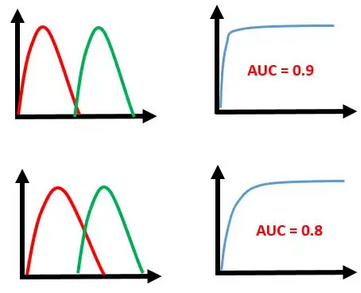

### ¿Se evidencian problemas de overfitting o underfitting?

In [ ]:
# sacan los datasets de prueba y test para contestar la pregunta de over o under fitting
X_ovun = clean_df1.drop("Churn", axis=1)
Y_ovun = clean_df1["Churn"]
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_ovun, Y_ovun, test_size = 0.3, stratify = Y_ovun, random_state = 33)

In [ ]:
v_score1, mod1 = lmodel

train_prediction = mod1.predict(X_train1)
test_prediction = mod1.predict(X_test1)

print("Predicción con el conjunto de entrenamiento: \n", classification_report(Y_train1, train_prediction))
print("Predicción con el conjunto de evaluación: \n",classification_report(Y_test1, test_prediction))

Predicción con el conjunto de entrenamiento: 
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      3086
           1       0.50      0.79      0.62      1114

    accuracy                           0.74      4200
   macro avg       0.70      0.75      0.71      4200
weighted avg       0.80      0.74      0.75      4200

Predicción con el conjunto de evaluación: 
               precision    recall  f1-score   support

           0       0.92      0.69      0.79      1322
           1       0.50      0.84      0.62       478

    accuracy                           0.73      1800
   macro avg       0.71      0.77      0.71      1800
weighted avg       0.81      0.73      0.75      1800



#### overfiting: analizando los resultados tanto de precisión como de recall, varian entre un 0.01 a un 0.3%, lo que nos indica que no hay sobreajuste.
### Underfitting: analizando las métricas con el conjunto de evaluación, tenemos una precisiones entre 0.92 a 0.5 en el peor de los casos, consideramos que sí sufre un poco falto de ajuste, sobre todo para clasificar los valores en los cuales es positivo el Churn

In [ ]:
print(train_prediction)

[0 1 1 ... 0 0 1]


## REENTRENAMIENTO

In [ ]:
def reentrenamiento(df1,df2):
    clean_df1 = cleaning(df1)
    clean_df2 = cleaning(df2)
    rtrain_df = pd.concat([clean_df1, clean_df2], axis=0)

    #dividir el X y Y 
    X = rtrain_df.drop("Churn", axis=1)
    Y = rtrain_df["Churn"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 33)

    scaler = StandardScaler()

    #se hace el pipeline con la regresión logística
    logistic = LogisticRegression(max_iter=1000, tol=0.1, class_weight = 'balanced', multi_class='multinomial', random_state = 33)
    pipe = Pipeline(steps=[("scaler", scaler), ("polynomial", PolynomialFeatures()) ,("logistic", logistic)])
    param_grid = {
        "polynomial__degree": [1, 2],
        "polynomial__interaction_only":[True, False],
        "polynomial__include_bias":[True, False],
        "logistic__penalty":['l2', 'elasticnet'],
        "logistic__solver":['liblinear', 'saga'],    
    }

    #se busca el mejor modelo y regresa el score
    logistic_rtmodel = GridSearchCV(pipe, param_grid, n_jobs=2, scoring = 'roc_auc', cv=5).fit(X, Y)
    #score_logistic = roc_auc_score(Y_test, logistic_model.predict_proba(X_test)[:, 1])

    #v_score_logistic = cross_val_score(logistic_model, X_train, Y_train, cv=5, scoring='roc_auc').mean()
    
    return logistic_rtmodel

In [ ]:
# Lectura del segundo dataset de entrenamiento
url2 = "https://raw.githubusercontent.com/foramirez50/CDA/main/Taller4/DataSet_Entrenamiento_v2.json"
df2 = pd.read_json(url2)

### PROCESAMIENTO

In [ ]:
#llamamos el modelo que ya se tiene 
first_model = jbl.load('my_model.pkl')

# guardamos el modelo reentrenado en una variable
retrain_model = reentrenamiento(df,df2)

### COMPARACIÓN DE LOS 2 MODELOS

In [ ]:
clean_df2 = cleaning(df2)
rtrain_df = pd.concat([clean_df1, clean_df2], axis=0)

X_last = rtrain_df.drop("Churn", axis=1)
Y_last = rtrain_df["Churn"]
X_train, X_test, Y_train, Y_test = train_test_split(X_last, Y_last, test_size = 0.3, stratify = Y_last, random_state = 33)

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1543
           1       0.49      0.81      0.61       557

    accuracy                           0.73      2100
   macro avg       0.70      0.75      0.70      2100
weighted avg       0.80      0.73      0.74      2100

0.8297750540752178


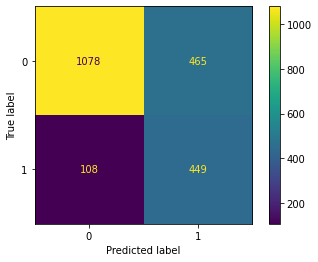

In [ ]:
predictions_v1 = first_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(Y_test, predictions_v1)
print(classification_report(Y_test, predictions_v1))
print(roc_auc_score(Y_test, first_model.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1543
           1       0.51      0.79      0.62       557

    accuracy                           0.74      2100
   macro avg       0.71      0.76      0.71      2100
weighted avg       0.80      0.74      0.76      2100

0.8345816108189996


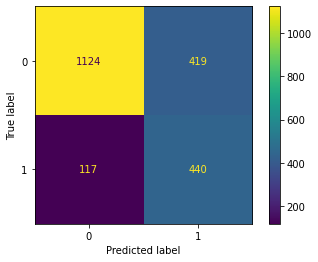

In [ ]:
predictions_v2 = retrain_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(Y_test, predictions_v2)
print(classification_report(Y_test, predictions_v2))
print(roc_auc_score(Y_test, retrain_model.predict_proba(X_test)[:, 1]))

In [ ]:
# se lee el dataset a predecir
url3 = "https://raw.githubusercontent.com/foramirez50/CDA/main/Taller4/DataSet_Prediccion.json"
df3 = pd.read_json(url3)

In [ ]:
def get_final_pred_mv1(dataset):

    # se limpia para que pueda ser ingerido por el modelo
    clean_df3 = cleaning_1(dataset)

    # se hace la predicción con el último modelo
    df_predicted = pd.DataFrame(retrain_model.predict(clean_df3)).replace([0, 1],['No', 'Yes'])
    df_precited_proba = pd.DataFrame(retrain_model.predict_proba(clean_df3)[:, 1])
    df_predicted["proba"] = df_precited_proba
    df_predicted.columns =['Churn', 'Proba']

    return df_predicted

## BONO!!!

In [ ]:
def get_final_pred_mv0(dataset):

    # se limpia para que pueda ser ingerido por el modelo
    clean_df3 = cleaning_1(dataset)

    # se hace la predicción con el primer modelo
    df_predicted = pd.DataFrame(first_model.predict(clean_df3)).replace([0, 1],['No', 'Yes'])
    df_precited_proba = pd.DataFrame(first_model.predict_proba(clean_df3)[:, 1])
    df_predicted["proba"] = df_precited_proba
    df_predicted.columns =['Churn', 'Proba']

    return df_predicted

In [ ]:
print(get_final_pred_mv1(df3).head(10))
print(get_final_pred_mv0(df3).head(10))

  Churn     Proba
0   Yes  0.773903
1   Yes  0.908847
2    No  0.412959
3    No  0.063696
4   Yes  0.545185
5   Yes  0.632094
6   Yes  0.709613
7   Yes  0.603133
8    No  0.020007
9   Yes  0.770729
  Churn     Proba
0   Yes  0.786923
1   Yes  0.881516
2   Yes  0.702191
3    No  0.118040
4   Yes  0.677070
5   Yes  0.779126
6   Yes  0.609935
7   Yes  0.734856
8    No  0.009930
9   Yes  0.813835
